## Wstęp do uczenia maszynowego 
### Praca domowa 5
#### Jakub Piwko, Malwina Wojewoda 
zespół walidacyjny
***

### Pakiety

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

### Wczytanie i analiza danych

In [41]:
X = pd.read_csv('urbanGB.txt', names = ['x','y'], header=None)

In [42]:
X.head()

,x,y
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


In [43]:
X.x = 1.7 * X.x

In [44]:
X.head()

,x,y
0,-0.528683,53.7802
1,-5.291335,55.8706
2,-0.150506,51.3806
3,-0.555551,51.4476
4,-6.709101,51.6594


In [45]:
X = X.to_numpy()

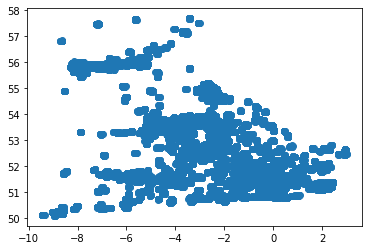

In [46]:
plt.scatter(X[:,0],X[:,1])
plt.show()

Jako, że mamy do czynienia ze współrzędymi kartograficznymi, odlegości między punktami, które będziemy obliczać mogą być nieprecyzyjne ze względu na zakrzywienie ziemi. W opisie danych dodano wskazówkę, aby przemnożyć dlugość geograficzną przez wskaźnik 1.7, aby uzyskać najbardziej przybliżone odległości. 

Budowniczy nie zdecydowali się na ten krok, dlatego my spróbujemy dokonać zmian, aby porównać wyniki. 

In [ ]:
## na razie stop bo jednak nie wiem co w tym przypadku w ogóle ma robić walidacja

### KMean i metoda łokcia 

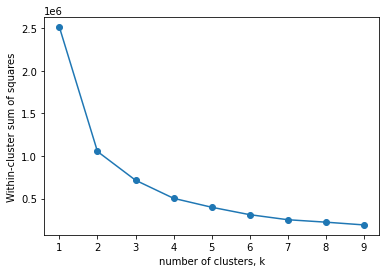

In [47]:
ks = range(1, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X)
    scores.append(model.score(X) * -1)
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Budowniczy wykorzystali metodą łokcia do znalezienia optymalnej liczby klastrów. Według ich interepretacji, punkt przegięcia i tym samym podział wypada dla liczby klastrów 4 lub 5. My sprawdziwmy jeszcze dla wartości 3.

In [49]:
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

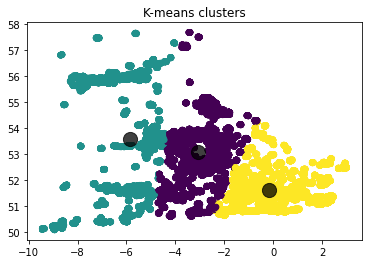

In [51]:
plot_kmeans_clusters(X, n_clusters=3)

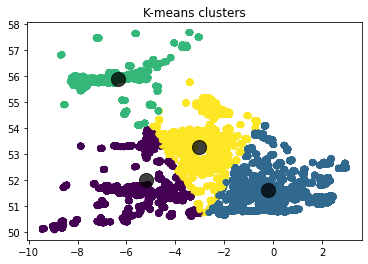

In [52]:
plot_kmeans_clusters(X, n_clusters=4)

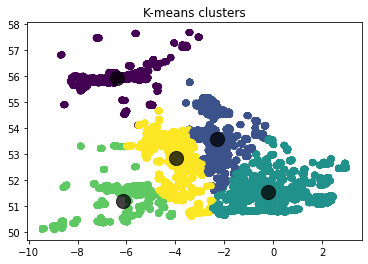

In [53]:
plot_kmeans_clusters(X, n_clusters=5)

Po przeskalowaniu długości geograficznej można dostrzec, że klastry zbudowały się odrobinę inaczej. Nadal aktualny jest wniosek, że 4 i 5 klastrów dzieli lepiej punkty w grupy.

Spróbujemy jeszcze zbadać optymalną liczbę klastrów metodą silhouette. Ze względu na dużą złożoność obliczeniową spróbujemy przeprowadzić dobór na zmniejszonym zbiorze.

#### Metoda silhouette

In [ ]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.1, random_state=42).astype('float32')

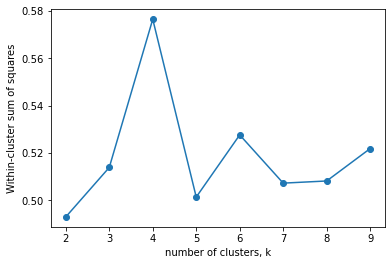

In [17]:
from sklearn.metrics import silhouette_score

ks = range(2, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(df)
    scores.append(silhouette_score(df, labels))
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Można zauważyć, że według tej miary najoptymalniejszym doborem liczby klastrów byłoby 2 lub 5. POrównajmy więc jak wygląda klastrowanie dla liczby klastrów 2, 4, 5.

### K-medoids